<a href="https://colab.research.google.com/github/igoravelli/brazilian_soccer_championship_analysis/blob/main/Average_of_cards_in_home_team_matches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and settings

In [7]:
import pandas as pd
import numpy as np

from google.colab import auth
from google.cloud import bigquery
from google.colab import data_table

data_table.enable_dataframe_formatter()
auth.authenticate_user()

project = 'brasileirao-362523'
schema = '3_gold'
location = 'US'

client = bigquery.Client(project=project, location=location)

In [8]:
# @title get dim_match
dim_match = client.query(f"""
      SELECT * FROM `{project}.{schema}.dimMatch`
    """).to_dataframe()

dim_match.set_index('pk_match', inplace=True)
dim_match.head()

,stadium,away_team,home_team,round,match_date,championship_year,home_team_squad,away_team_squad,winner,loser
pk_match,,,,,,,,,,
1114,mane_garrincha,vasco,brasiliense,1,2005-04-24 18:10:00,2005,N/A,N/A,None,None
1148,boca_do_jacare,fluminense,brasiliense,4,2005-05-15 18:10:00,2005,N/A,N/A,fluminense,brasiliense
1167,boca_do_jacare,parana,brasiliense,6,2005-05-29 16:00:00,2005,N/A,N/A,brasiliense,parana
1183,mane_garrincha,corinthians,brasiliense,8,2005-06-18 16:00:00,2005,N/A,N/A,corinthians,brasiliense
1213,boca_do_jacare,athletico-pr,brasiliense,10,2005-07-03 18:10:00,2005,N/A,N/A,brasiliense,athletico-pr


In [9]:
# @title get dim_team
dim_team = client.query(f"""
      SELECT * FROM `{project}.{schema}.dimTeam`
    """).to_dataframe()

dim_team.set_index('pk_team', inplace=True)
dim_team.head()

,team,state,stadium,coach,start_id,end_id
pk_team,,,,,,
1225,csa,AL,estadio_rei_pele,M._Ribeiro_Cabo,6513,6589
1226,csa,AL,estadio_rei_pele,A._Fucks,6601,6861
1227,csa,AL,estadio_rei_pele,G._Santos_Vasconcelo,6869,6879
1079,bahia,BA,itaipava_arena_fonte_nova,N/A,8,4612
1080,bahia,BA,itaipava_arena_fonte_nova,M._dos_Santos_Goncalves,4623,4730


In [10]:
# @title get fact_events
fact_events = client.query(f"""
      SELECT * FROM `{project}.{schema}.factEvents`
    """).to_dataframe()

fact_events.set_index('pk_fact_event', inplace=True)
fact_events.head()

,fk_match_id,fk_team_id,fk_calendar_id,fk_player_id,fk_stadium_id,event,minute,extra_time
pk_fact_event,,,,,,,,
2000001,4607,1268,20140419,14367,100104,goal,31,0
2000002,4607,1231,20140419,15053,100104,yellow,44,0
2000003,4607,1268,20140419,11742,100104,goal,45,0
2000004,4607,1268,20140419,14030,100104,goal,59,0
2000005,4607,1231,20140419,14206,100104,yellow,66,0


# Transformations

In [11]:
# @title join the dataframes dim_match, fact_events
mart = fact_events.merge(dim_match,
                         how = 'left',
                         left_on = 'fk_match_id',
                         right_on = 'pk_match').merge(dim_team,
                                                      how = 'left',
                                                      left_on = 'fk_team_id',
                                                      right_on = 'pk_team').rename(columns={'team': 'team_name'})

mart.head()

,fk_match_id,fk_team_id,fk_calendar_id,fk_player_id,fk_stadium_id,event,minute,extra_time,stadium_x,away_team,...,home_team_squad,away_team_squad,winner,loser,team_name,state,stadium_y,coach,start_id,end_id
0,4607,1268,20140419,14367,100104,goal,31,0,maracana,figueirense,...,N/A,N/A,fluminense,figueirense,fluminense,RJ,maracana,N/A,6,4607
1,4607,1231,20140419,15053,100104,yellow,44,0,maracana,figueirense,...,N/A,N/A,fluminense,figueirense,figueirense,SC,orlando_scarpelli,V._Eutropio,4607,4623
2,4607,1268,20140419,11742,100104,goal,45,0,maracana,figueirense,...,N/A,N/A,fluminense,figueirense,fluminense,RJ,maracana,N/A,6,4607
3,4607,1268,20140419,14030,100104,goal,59,0,maracana,figueirense,...,N/A,N/A,fluminense,figueirense,fluminense,RJ,maracana,N/A,6,4607
4,4607,1231,20140419,14206,100104,yellow,66,0,maracana,figueirense,...,N/A,N/A,fluminense,figueirense,figueirense,SC,orlando_scarpelli,V._Eutropio,4607,4623


In [12]:
mart.columns

Index(['fk_match_id', 'fk_team_id', 'fk_calendar_id', 'fk_player_id',
       'fk_stadium_id', 'event', 'minute', 'extra_time', 'stadium_x',
       'away_team', 'home_team', 'round', 'match_date', 'championship_year',
       'home_team_squad', 'away_team_squad', 'winner', 'loser', 'team_name',
       'state', 'stadium_y', 'coach', 'start_id', 'end_id'],
      dtype='object')

In [13]:
# @title select the columns
cols = [
    'fk_match_id',
    'team_name',
    'home_team',
    'event'
]

df = mart[cols]

In [14]:
# @title create the is_home_team column
df['is_home_team'] = df['team_name'] == df['home_team']

<ipython-input-14-6cd031524e2a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_home_team'] = df['team_name'] == df['home_team']


In [15]:
# @title pivot the dataframe
pivot = pd.pivot_table(df,
                       values = ['fk_match_id'],
                       columns = ['event'],
                       index = ['is_home_team'],
                       aggfunc = ['count'],
                       fill_value = 0)

pivot[[('count', 'fk_match_id',  'total_matches')]] = len(df['fk_match_id'].unique())
pivot.head()

count                          
             fk_match_id                          
event               goal  red yellow total_matches
is_home_team                                      
False               2827  443   7370          3035
True                4254  296   6653          3035

In [16]:
# @title get only the level 2 index column
pivot.columns = pivot.columns.get_level_values(2)

In [17]:
# @title create the columns with metrics
pivot['avg_cards'] = pivot.apply(lambda x: (x['yellow'] + x['red']) / x['total_matches'], axis=1)
pivot['avg_red_cards'] = pivot.apply(lambda x: x['red'] / x['total_matches'], axis=1)
pivot['avg_yellow_cards'] = pivot.apply(lambda x: x['yellow'] / x['total_matches'], axis=1)
pivot['avg_goals'] = pivot.apply(lambda x: x['goal'] / x['total_matches'], axis=1)

In [18]:
print(pivot.columns)
pivot.head()

Index(['goal', 'red', 'yellow', 'total_matches', 'avg_cards', 'avg_red_cards',
       'avg_yellow_cards', 'avg_goals'],
      dtype='object', name='event')


event,goal,red,yellow,total_matches,avg_cards,avg_red_cards,avg_yellow_cards,avg_goals
is_home_team,,,,,,,,
False,2827,443,7370,3035,2.574300,0.145964,2.428336,0.931466
True,4254,296,6653,3035,2.289621,0.097529,2.192092,1.401647


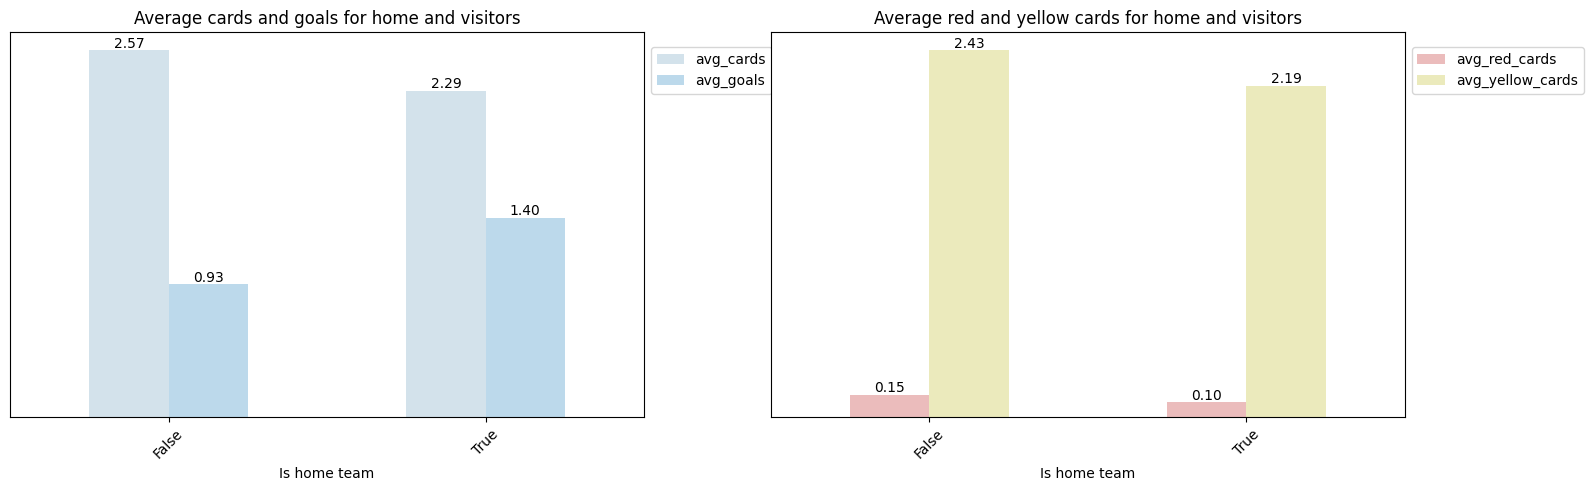

In [19]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(nrows = 1,
                               ncols = 2,
                               figsize = (18,5))

xlabel = 'Is home team'

# first plot
pivot.plot(
    ax = ax1,
    kind = 'bar',
    y = ['avg_cards','avg_goals'],
    color = ['#D3E2EB', '#BCD9EB'],
    title = 'Average cards and goals for home and visitors',
    xlabel = xlabel,
    rot = 45
)

# second plot
pivot.plot(
    ax = ax2,
    kind = 'bar',
    y = ['avg_red_cards', 'avg_yellow_cards'],
    color = ['#EBBCBC', '#EBEABC'],
    title = 'Average red and yellow cards for home and visitors',
    xlabel = xlabel,
    rot = 45
)

for x in [ax1, ax2]:
    x.get_yaxis().set_visible(False)
    for p in x.patches:
        height = p.get_height()
        x.annotate(f'{height:.2f}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center',
                    va='center',
                    xytext=(0, 5),
                    textcoords='offset points')
    x.legend(loc = 'center left', bbox_to_anchor = (1, 0.9))


plt.show()


# Conclusion

As we can see in the chart above, the home teams receive fewer cards and make more goals.
The main observation is the average goal increase when a team plays at home, which was an increase of 50% on its average.

This can be explained by the pressure of the home public that makes visitors push harder.